In [1]:
sc

<SparkContext master=local[*] appName=pyspark-shell>

# Study Station 235 Castrcum (Amsterdan) LSTM

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
from dateutil.parser import parse 
from pyspark.sql.types import *
from pyspark.sql.functions import *
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
plt.rcParams.update({'figure.figsize': (10, 7), 'figure.dpi': 120})

In [4]:
hadoopUrl = 'hdfs://hadoop-vm.internal.cloudapp.net:9000'
station = 235
data_files = f'{hadoopUrl}/precipitation/data/{station}/*.parquet'

# Obtain dataset
df = spark.read.parquet(data_files) \
        .withColumn("precipitation", col("precipitation").cast("float")) \
        .select("date","precipitation") \
        .toPandas()

In [5]:
# Set the date column as the index and ensure it's a DatetimeIndex
df.set_index('date', inplace=True)
df.index = pd.to_datetime(df.index)
df = df.sort_index()

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 34951 entries, 1927-07-01 to 2023-03-10
Data columns (total 1 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   precipitation  34951 non-null  float32
dtypes: float32(1)
memory usage: 409.6 KB


In [7]:
def check_missing_values(df):
    # Check for nulls
    print(f"Number of null value in timeseries {df.precipitation.isnull().sum()}")

    # Check there is data all days of the timeseries
    start_date = pd.Timestamp(df.index.min())
    end_date = pd.Timestamp(df.index.max())

    # Create a date range for the entire period
    full_date_range = pd.date_range(start=start_date, end=end_date, freq='D')

    # Check for missing dates
    missing_dates = full_date_range.difference(df.index)

    if not missing_dates.empty:
        print(f"There are {len(missing_dates)} missing dates in the index:")
        print(missing_dates)
    else:
        print("There are no missing dates in the index.")

check_missing_values(df)

Number of null value in timeseries 0
There are 1 missing dates in the index:
DatetimeIndex(['1932-01-01'], dtype='datetime64[ns]', freq=None)


# Fill missing value with precipitation of the closest stations to 

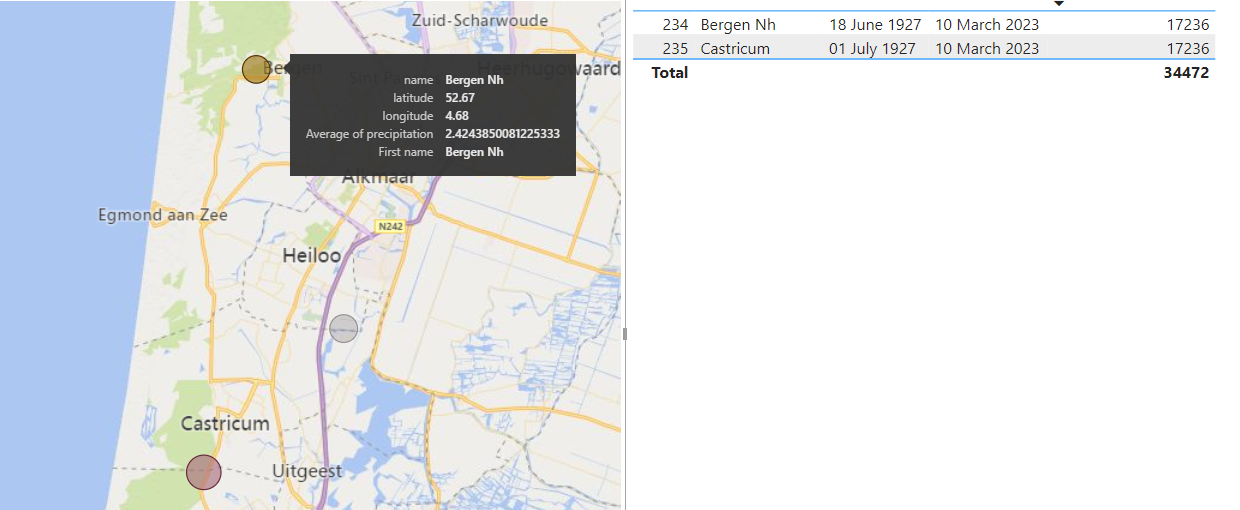

In [8]:
df.at['1932-01-01','precipitation'] = 0.30

In [9]:
check_missing_values(df)

Number of null value in timeseries 0
There are no missing dates in the index.


## Plot series different time scales. Remove outliers


In [10]:
def seasonality_plots(grouped, freq="1D", start = '2015-01-01', end = '2023-01-01', remove_outliers = True):
    df_s = grouped[(grouped.index >= start) & (grouped.index <= end)]

    if(remove_outliers):
        # Calculate the IQR
        Q1 = df_s['precipitation'].quantile(0.25)
        Q3 = df_s['precipitation'].quantile(0.75)
        IQR = Q3 - Q1

        # Define the bounds for outliers
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR


        # Filter out the outliers
        df_s = df_s[(df_s['precipitation'] >= lower_bound) & (df_s['precipitation'] <= upper_bound)]

    # Prepare data
    df_s['year'] = [d.year for d in df_s.index]
    df_s['month'] = [d.strftime('%b') for d in df_s.index]
    years = df_s['year'].unique()
    
    # Draw Plot
    fig, axes = plt.subplots(1, 2, figsize=(20,7), dpi= 80)
    sns.boxplot(x='year', y='precipitation', data=df_s, ax=axes[0])
    sns.boxplot(x='month', y='precipitation', data=df_s.loc[~df_s.year.isin([1900, 2023]), :])

    # Set Title
    axes[0].set_title(f'{freq} Year-wise Box Plot\n(The Trend)', fontsize=18); 
    axes[1].set_title(f'{freq} Month-wise Box Plot\n(The Seasonality)', fontsize=18)
    plt.show()
    
    
    x = df_s.index
    y1 = df_s['precipitation'].values

    # Plot
    fig, ax = plt.subplots(1, 1, figsize=(16,5), dpi= 120, )
    plt.fill_between(x, y1=y1, y2=-y1, alpha=0.5, linewidth=2, color='seagreen')
    plt.ylim(-15, 15)
    plt.title(f'Precipitation {freq} (Two Side View)', fontsize=16)
    plt.hlines(y=0, xmin=np.min(df_s.index), xmax=np.max(df_s.index), linewidth=.5)
    plt.show()

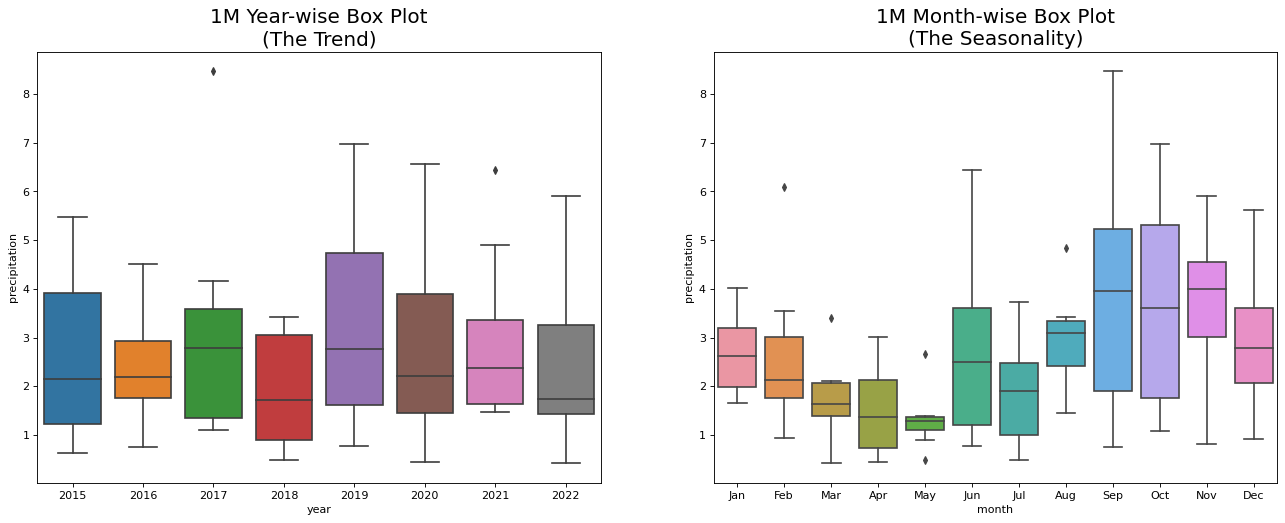

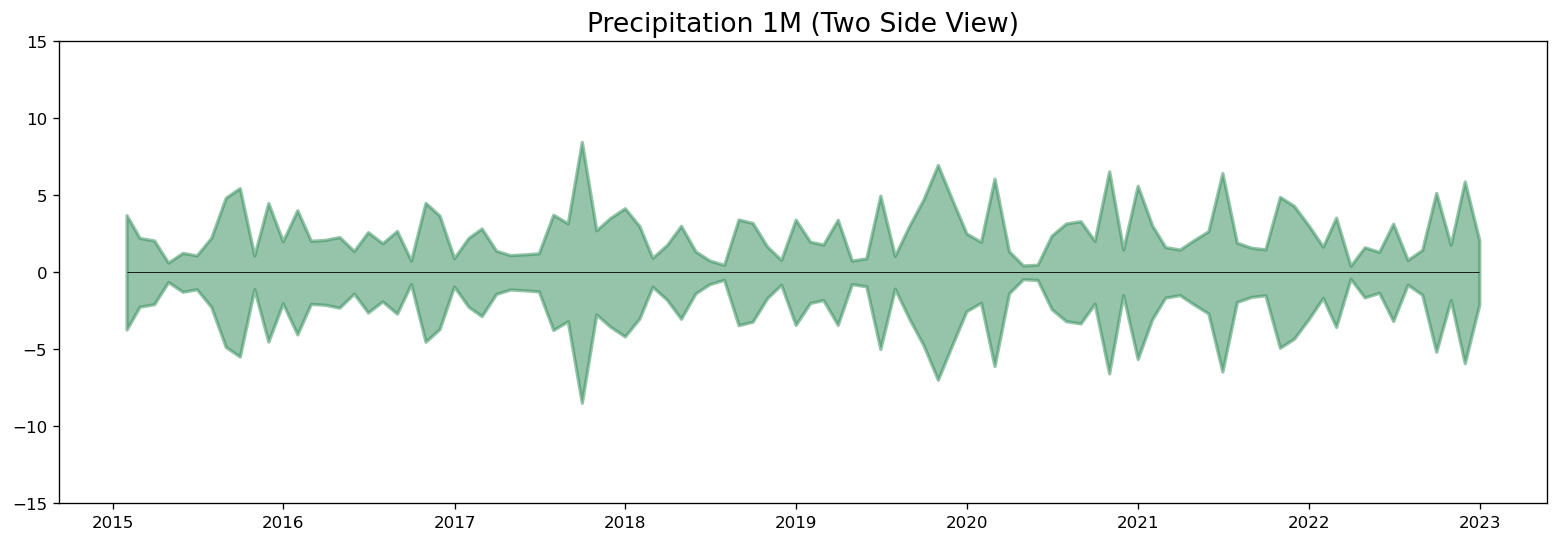

In [11]:
df_seasson = df.resample('1M').mean()
seasonality_plots(df_seasson,freq="1M",remove_outliers=False)

# Seasonality Decomposition Monthly

In [12]:
#%pip install statsmodels

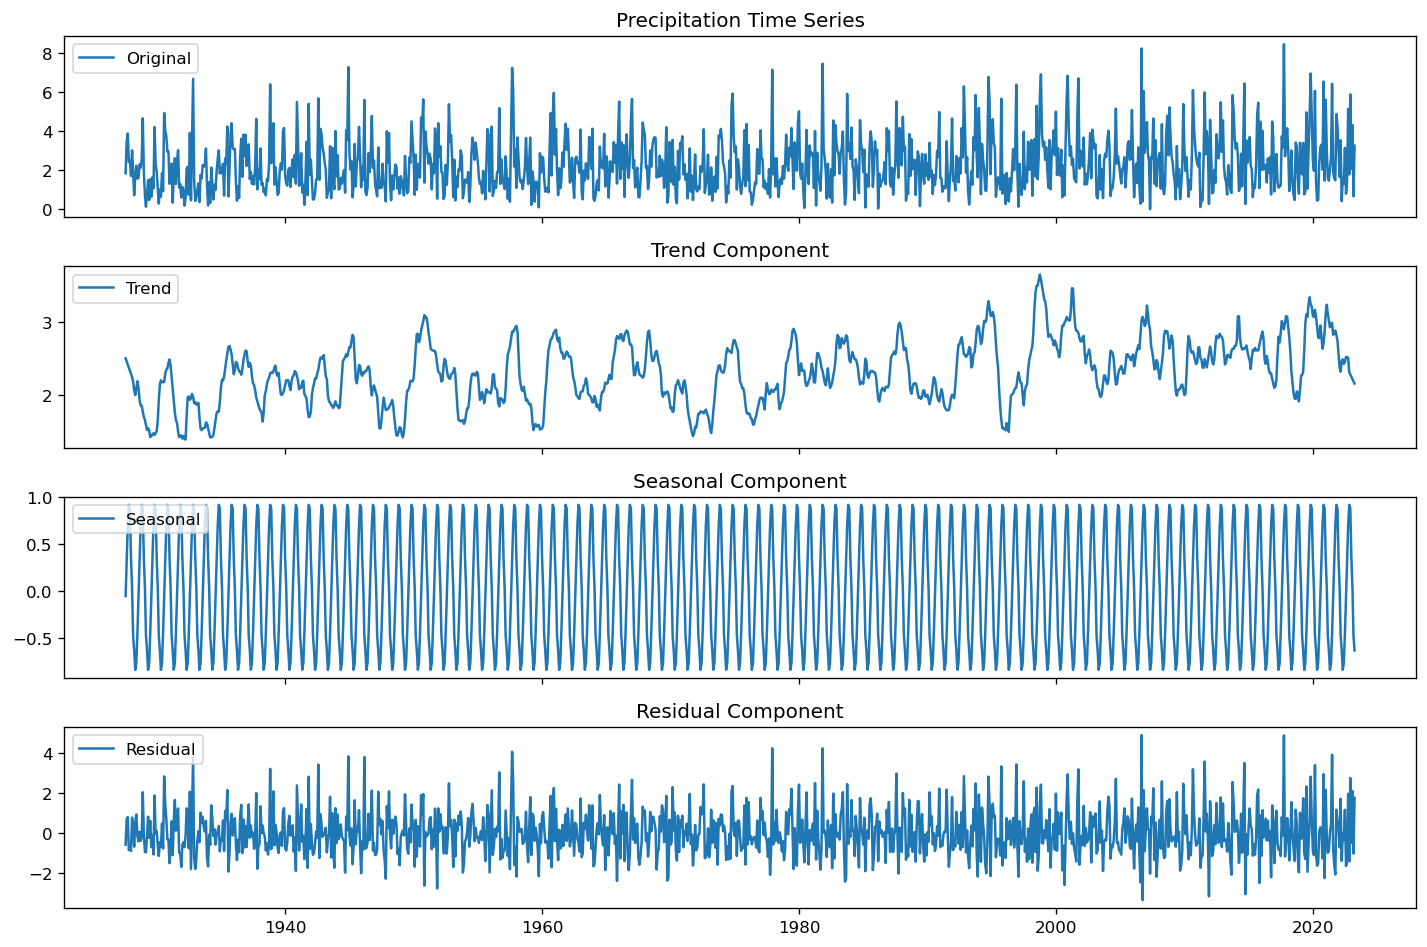

In [13]:
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse
%matplotlib inline

df_seasson = df.resample('1M').mean()
df_seasson = df_seasson.sort_index()
decomposition = seasonal_decompose(df_seasson['precipitation'], model='additive', extrapolate_trend='freq')
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(12, 8), sharex=True)

# Plot the original time series
ax1.plot(df_seasson['precipitation'], label='Original')
ax1.legend(loc='upper left')
ax1.set_title('Precipitation Time Series')

# Plot the trend component
ax2.plot(decomposition.trend, label='Trend')
ax2.legend(loc='upper left')
ax2.set_title('Trend Component')

# Plot the seasonal component
ax3.plot(decomposition.seasonal, label='Seasonal')
ax3.legend(loc='upper left')
ax3.set_title('Seasonal Component')

# Plot the residual component
ax4.plot(decomposition.resid, label='Residual')
ax4.legend(loc='upper left')
ax4.set_title('Residual Component')

plt.tight_layout()
plt.show()


# Residuals 
Residuals are useful in checking whether a model has adequately captured the information in the data. A good forecasting method will yield residuals with the following properties:

1. The residuals are uncorrelated. If there are correlations between residuals, hen there is information left in the residuals which should be used in omputing forecasts.
2. The residuals have zero mean. If the residuals have a mean other than zero, hen the forecasts are biased.

> Hyndman, R.J., A., G. (2018) Forecasting: Principles and Practice. 2nd edn. Monash University, Australia.

In [14]:
decomposition.resid.describe()

count    1149.000000
mean        0.002319
std         1.171401
min        -3.369995
25%        -0.775994
50%        -0.100498
75%         0.683696
max         4.883430
Name: resid, dtype: float64

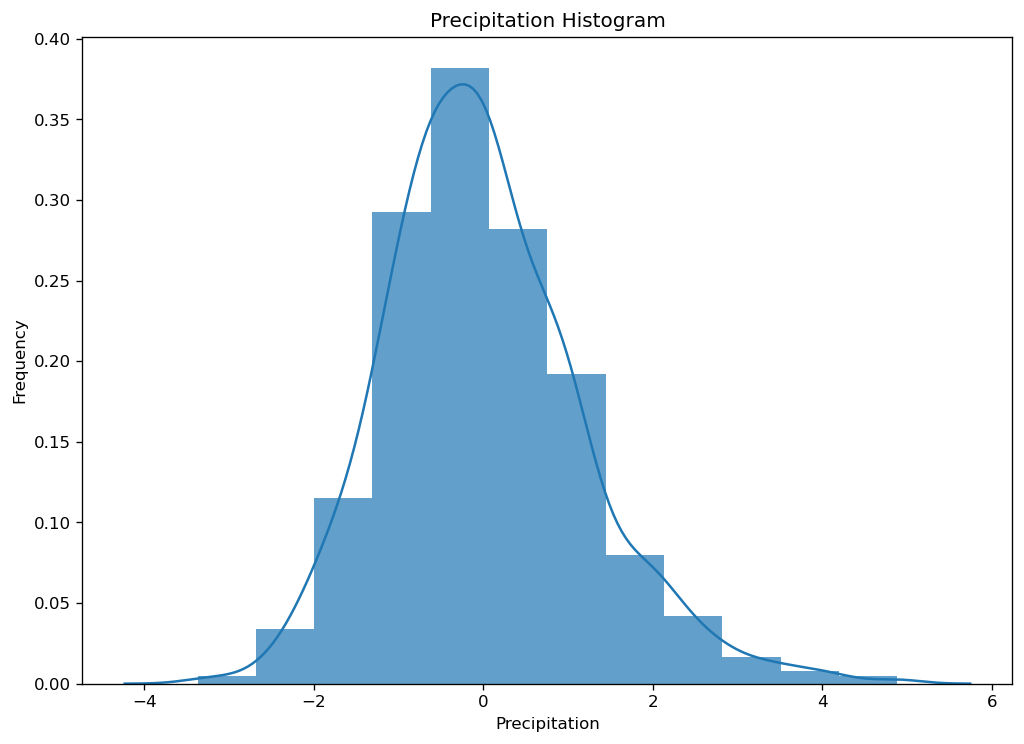

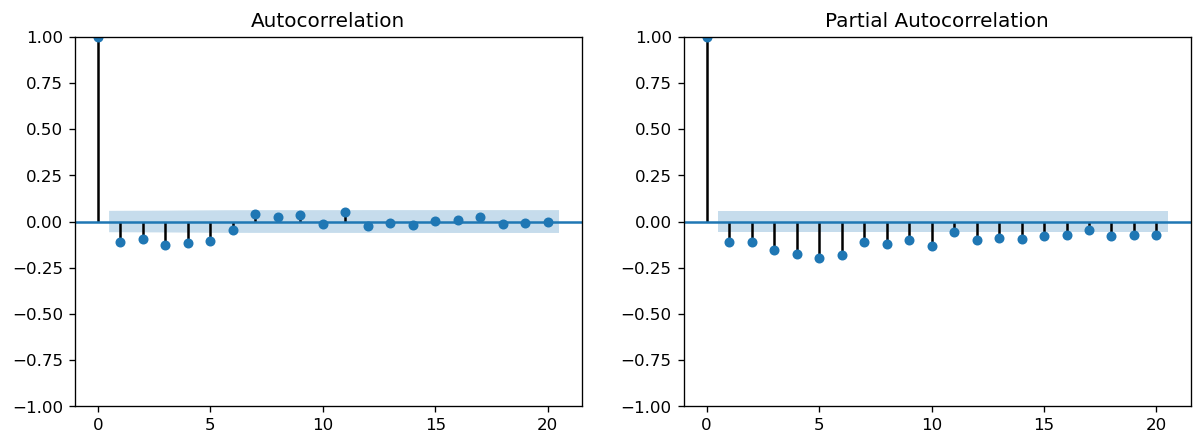

In [15]:
### Autocorrelation of residuals
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Calculate the histogram data (bin edges and counts)
ax = sns.distplot(decomposition.resid, bins=12, kde=True, hist_kws={"alpha": 0.7})

# Add labels to the histogram
plt.xlabel('Precipitation')
plt.ylabel('Frequency')
plt.title('Precipitation Histogram')


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
plot_acf(decomposition.resid, lags=20, ax=ax1)
plot_pacf(decomposition.resid, lags=20, ax=ax2)
plt.show()


> No information left on the residuals

# LSTM

In [16]:
import os
import tensorflow as tf
import logging

# Suppres tensorflow warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # 0: all messages, 1: filter out INFO, 2: filter out WARNING, 3: filter out ERROR
tf.get_logger().setLevel('ERROR')  # Set the TensorFlow logger level to ERROR
logging.getLogger('tensorflow').setLevel(logging.ERROR)  # Set the Python logger level for TensorFlow to ERROR


from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.wrappers.scikit_learn import KerasRegressor
from keras.callbacks import EarlyStopping



2023-04-04 21:48:53.085164: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-04 21:48:53.853180: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/intel/compilers_and_libraries_2018.1.163/linux/tbb/lib/intel64_lin/gcc4.7:/opt/intel/compilers_and_libraries_2018.1.163/linux/compiler/lib/intel64_lin:/opt/intel/compilers_and_libraries_2018.1.163/linux/mkl/lib/intel64_lin::/usr/local/cuda/lib64:/usr/local/cuda/extras/CUPTI/lib64/
2023-04-04 21:48:53.853298: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not

In [31]:
def remove_outlier(df):
    # Calculate the IQR
    Q1 = df['precipitation'].quantile(0.25)
    Q3 = df['precipitation'].quantile(0.75)
    IQR = Q3 - Q1

    # Define the bounds for outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Filter out the outliers
    return df[(df['precipitation'] >= lower_bound) & (df['precipitation'] <= upper_bound)]

# Hyper parameters
hyper_parameters = {
    'freq' : '1M',
    'look_back' : 12,
    'units' : 12,
    'dropout_rate' : 0.2,
    'optimizer' : 'adam'
}

def get_scaled_data(df, hyper_parameters):
    # get dataset
    df_seasson = df.resample(hyper_parameters['freq']).mean()
    
    # Scale data
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(df_seasson)
    return scaled_data


def create_sequences(data, look_back):
    X, y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i:(i + look_back), 0])
        y.append(data[i + look_back, 0])
    return np.array(X), np.array(y)

def create_rnn(hyper_parameters):
    units = hyper_parameters['units']
    look_back = hyper_parameters['look_back']
    optimizer = hyper_parameters['optimizer']
    dropout_rate = hyper_parameters['dropout_rate']
    
    print("Hyper-parameters:")
    print(f"\tfreq: { hyper_parameters['freq']}")
    print(f"\tunits: {units}")
    print(f"\tlook_back: {look_back}")
    print(f"\tdropout_rate: {dropout_rate}")
    print(f"\toptimizer: {optimizer}")
    
          
    
    model = Sequential()
    model.add(LSTM(units, input_shape=(look_back, 1), return_sequences=True))
    model.add(Dropout(dropout_rate))

    model.add(LSTM(units = units, return_sequences = True))
    model.add(Dropout(dropout_rate))

    model.add(LSTM(units = units, return_sequences = True))
    model.add(Dropout(dropout_rate))

    model.add(LSTM(units))
    model.add(Dropout(dropout_rate))

    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer=optimizer)
    
    return model

# Get Dataset
scaled_data = get_scaled_data(df, hyper_parameters)

look_back = hyper_parameters['look_back']

# Split dataset for test and training and create sequences.
train_data, test_data = train_test_split(scaled_data, test_size=0.2, shuffle=False)

# Create training and test sequences
train_X, train_y = create_sequences(train_data, look_back)
test_X, test_y = create_sequences(test_data, look_back)

train_X = train_X.reshape(train_X.shape[0], train_X.shape[1], 1)
test_X = test_X.reshape(test_X.shape[0], test_X.shape[1], 1)

# Create CNN model
model = create_rnn(hyper_parameters)

# Configure early stop
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=10, restore_best_weights=True)
model.fit(train_X, train_y, epochs=100, batch_size=5, verbose=1, validation_split=0.2, callbacks=[early_stopping])


predictions = model.predict(test_X)
rmse = np.sqrt(mean_squared_error(test_y, predictions.flatten()))
print(f"RMSE: {rmse}")

Hyper-parameters:
	freq: 1M
	units: 12
	look_back: 12
	dropout_rate: 0.2
	optimizer: adam
Epoch 1/100
145/145 [==============================] - 6s 17ms/step - loss: 0.0302 - val_loss: 0.0306
Epoch 2/100
145/145 [==============================] - 1s 10ms/step - loss: 0.0248 - val_loss: 0.0319
Epoch 3/100
145/145 [==============================] - 1s 10ms/step - loss: 0.0254 - val_loss: 0.0319
Epoch 4/100
145/145 [==============================] - 1s 10ms/step - loss: 0.0244 - val_loss: 0.0319
Epoch 5/100
145/145 [==============================] - 1s 10ms/step - loss: 0.0239 - val_loss: 0.0303
Epoch 6/100
145/145 [==============================] - 1s 10ms/step - loss: 0.0249 - val_loss: 0.0316
Epoch 7/100
145/145 [==============================] - 1s 10ms/step - loss: 0.0238 - val_loss: 0.0330
Epoch 8/100
145/145 [==============================] - 1s 10ms/step - loss: 0.0242 - val_loss: 0.0333
Epoch 9/100
145/145 [==============================] - 1s 10ms/step - loss: 0.0242 - val_loss:

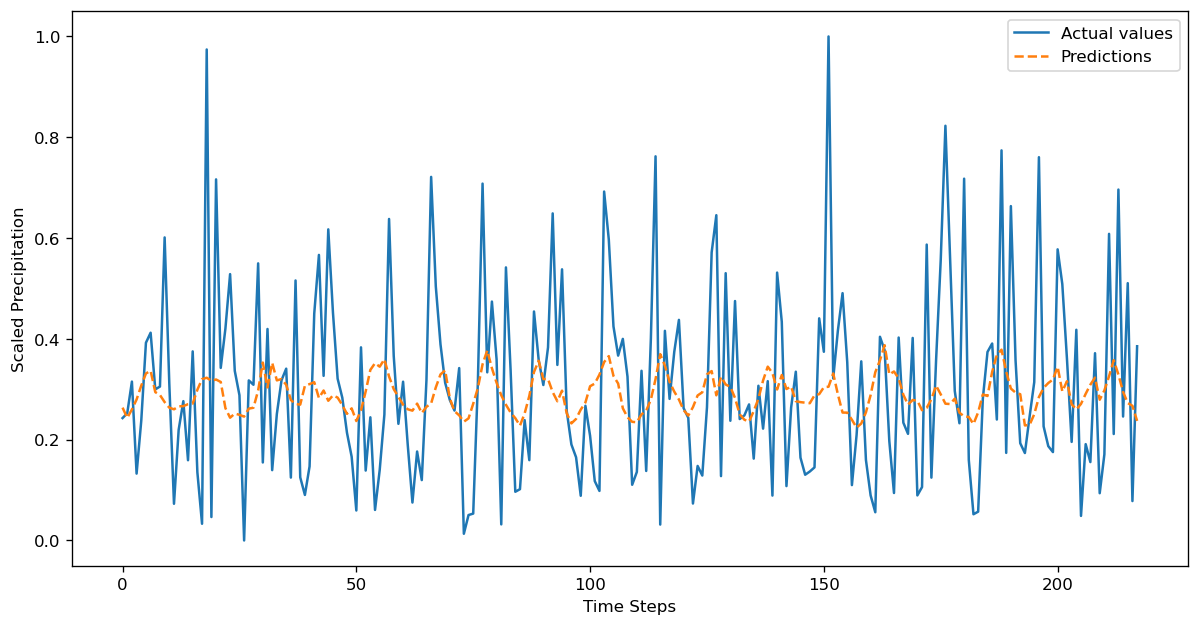

In [32]:
plt.figure(figsize=(12, 6))
plt.plot(test_y, label='Actual values')
plt.plot(predictions, label='Predictions', linestyle='dashed')
plt.xlabel('Time Steps')
plt.ylabel('Scaled Precipitation')
plt.legend()
plt.show()


## LSTM 2 RNN with hyper parameter tunning

In [35]:
X_train.shape

(908, 11, 1)

In [152]:
# Aggregate data on a monthly basis
df_monthly = df.resample('1M').mean()

# Define look_back
look_back = 12

# Prepare the dataset
def create_dataset(data, look_back=1):
    X, Y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i:(i + look_back), 0])
        Y.append(data[i + look_back, 0])
    return np.array(X), np.array(Y)

# Split into train and test sets
train, test = train_test_split(df_monthly, test_size=0.2, shuffle=False)
train_values = train.values.astype('float32')
test_values = test.values.astype('float32')

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
train_values = scaler.fit_transform(train_values)
test_values = scaler.transform(test_values)

# Create train and test datasets
X_train, y_train = create_dataset(train_values, look_back)
X_test, y_test = create_dataset(test_values, look_back)

# Reshape data for CNN input
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Build the LSTM-based CNN model
def create_model(units = 12, look_back = 12, optimizer='adam', dropout_rate = 0.2):
    
    model = Sequential()
    model.add(LSTM(units, input_shape=(look_back, 1), return_sequences=True))
    model.add(Dropout(dropout_rate))

    model.add(LSTM(units = units, return_sequences = True))
    model.add(Dropout(dropout_rate))

    model.add(LSTM(units))
    model.add(Dropout(dropout_rate))

    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer=optimizer)
    
    return model

# Perform hyperparameter tuning
model = KerasRegressor(build_fn=create_model, verbose=0)
param_grid = {
    'look_back' : [look_back],
    'epochs': [50],
    'batch_size': [16],
    'units' : [look_back],
    'dropout_rate' : [0.2],
    'optimizer': ['adam']
    
}

grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(X_train, y_train)

# This could take a few minutes to complete

In [153]:
grid_result.best_params_

{'batch_size': 16,
 'dropout_rate': 0.2,
 'epochs': 50,
 'look_back': 6,
 'optimizer': 'adam',
 'units': 6}

In [154]:
# Train the model
best_epochs = grid_result.best_params_['epochs']
best_batch_size = grid_result.best_params_['batch_size']
model = create_model(units =  grid_result.best_params_['units'],
                     look_back = grid_result.best_params_['look_back'],
                     optimizer= grid_result.best_params_['optimizer'], 
                     dropout_rate = grid_result.best_params_['dropout_rate'])

# Include Early Stop if learning doesn't improve on delta 0.00001 after 10 epochs
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=10, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=best_epochs, batch_size=best_batch_size, verbose=0, validation_split=0.2, callbacks=[early_stopping])


In [155]:
# Predict precipitation using the trained model
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)


7/7 [==============================] - 0s 2ms/step


In [156]:

# Invert the predictions and the ground truth values
train_predict = scaler.inverse_transform(train_predict)
y_train = scaler.inverse_transform(y_train.reshape(-1, 1))

test_predict = scaler.inverse_transform(test_predict)
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate evaluation metrics
train_rmse = np.sqrt(mean_squared_error(y_train, train_predict))
train_mae = mean_absolute_error(y_train, train_predict)
train_mape = np.mean(np.abs((y_train - train_predict) / y_train)) * 100
train_mase = train_mae / (np.mean(np.abs(y_train[1:] - y_train[:-1])))

test_rmse = np.sqrt(mean_squared_error(y_test, test_predict))
test_mae = mean_absolute_error(y_test, test_predict)
test_mape = np.mean(np.abs((y_test - test_predict) / y_test)) * 100
test_mase = test_mae / (np.mean(np.abs(y_test[1:] - y_test[:-1])))

print(f"Train RMSE: {train_rmse:.2f}, Test RMSE: {test_rmse:.2f}")
print(f"Train MAE: {train_mae:.2f}, Test MAE: {test_mae:.2f}")
print(f"Train MAPE: {train_mape:.2f}%, Test MAPE: {test_mape:.2f}%")
print(f"Train MASE: {train_mase:.2f}, Test MASE: {test_mase:.2f}")

Train RMSE: 1.33, Test RMSE: 1.65
Train MAE: 1.04, Test MAE: 1.25
Train MAPE: 94.55%, Test MAPE: 176.95%
Train MASE: 0.81, Test MASE: 0.74


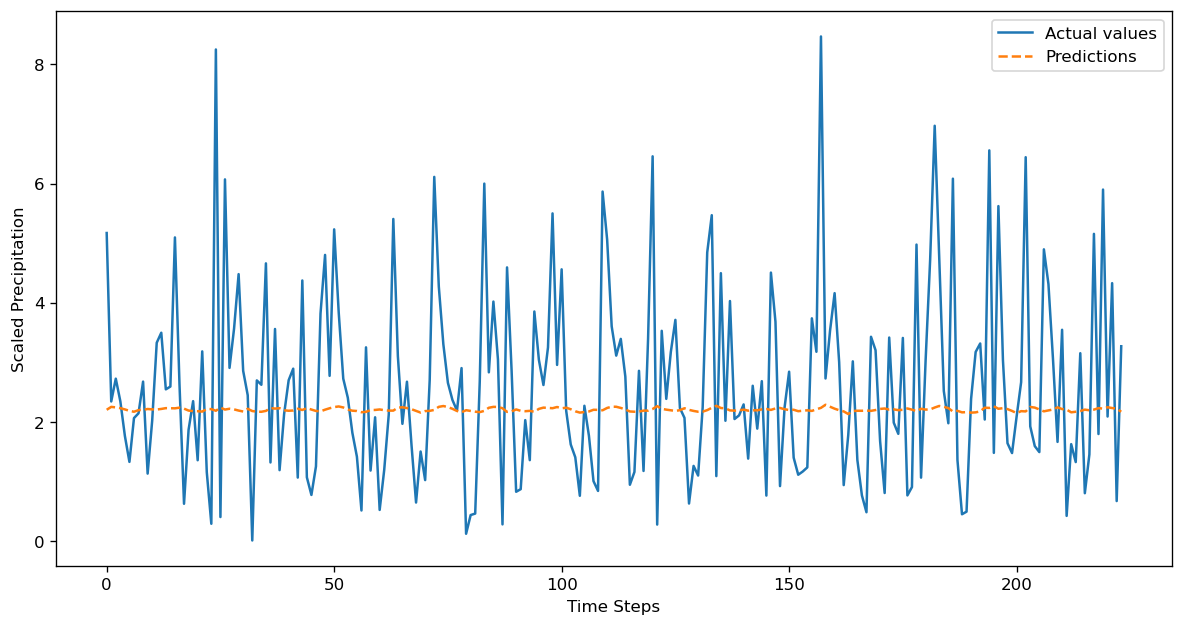

In [157]:
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='Actual values')
plt.plot(test_predict, label='Predictions', linestyle='dashed')
plt.xlabel('Time Steps')
plt.ylabel('Scaled Precipitation')
plt.legend()
plt.show()
